In [1]:
import sys
import pandas as pd
import random
import math
#import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import special
from numpy import genfromtxt
import operator

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (NVIDIA A100-PCIE-40GB) of compute capability 8.0 with 42.4Gb total memory.



In [3]:

def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    
    return sensitivity, specificity

def metrics(prediction, label, cut = 0.5):
    
    dichotomized = np.where(prediction > cut, 1, 0)
    sensitivity = np.sum(dichotomized[label==1]==1)/dichotomized[label==1].shape[0]
    specificity = np.sum(dichotomized[label==0]==0)/dichotomized[label==0].shape[0]
    precision = np.sum(dichotomized[label==1]==1)/np.sum(dichotomized==1)
    prop = np.sum(dichotomized==1)/label.shape[0]
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    print("Predicted doublet proportion:",prop)
    print("Precision:", precision)
    print("f1 score:", f1)
    
    return sensitivity, specificity




def reliability_f1(modality_reliability, modality_prediction, label):
    modality_reliability_trend = np.zeros((2, np.unique(modality_reliability).shape[0]))
    k=0
    for i in np.unique(modality_reliability):
        modality_reliability_trend[0,k]=i
        
        modality_prediction_subset = modality_prediction[modality_reliability==i]
        label_subset = label[modality_reliability==i]
        #modality_reliability_trend[1,k]=np.sum(modality_prediction_subset[label_subset==0]==0)/modality_prediction_subset[label_subset==0].shape[0]
        sensitivity_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/modality_prediction_subset[label_subset==1].shape[0]
        precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)
        modality_reliability_trend[1,k] = 2*precision_subset*sensitivity_subset/(precision_subset+sensitivity_subset)
        #print("precision_subset:",precision_subset)
        #print("sensitivity_subset:",sensitivity_subset)
        k+=1
    return modality_reliability_trend
    


## PB-1 DOGMA

In [4]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220215_1/

/ix1/wchen/Haoran/CPDD/ATAC/20220215_1


In [5]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/doublet_20220215_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/doublet_20220215_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_1/doublet_20220215_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/reliability_20220215_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_1/reliability_20220215_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_1/reliability_20220215_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.810470093191359


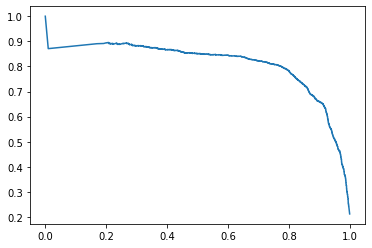

In [6]:

combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [7]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27060261208279235
Precision: 0.6872706745695738
f1 score: 0.7698387606702498


In [8]:
RNA_ks = 0.17891959062493024
ADT_ks = 0.17769096718239957
ATAC_ks = 2*0.2155402136639542

rna_reliability = np.round(rna_reliability*RNA_ks-0.05,1)+0.1
adt_reliability = np.round(adt_reliability*ADT_ks-0.05,1)+0.1
atac_reliability = np.round(atac_reliability*ATAC_ks-0.05,1)+0.1

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

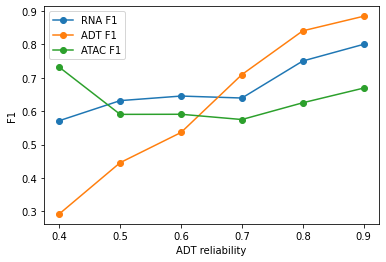

In [9]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-2 DOGMA

In [10]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220215_2/

/ix1/wchen/Haoran/CPDD/ATAC/20220215_2


In [11]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/doublet_20220215_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/doublet_20220215_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_2/doublet_20220215_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/reliability_20220215_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220215_2/reliability_20220215_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220215_2/reliability_20220215_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220215_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7902983905342518


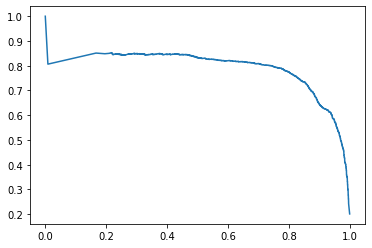

In [12]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [13]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)


Predicted doublet proportion: 0.2847298787210584
Precision: 0.638673765730881
f1 score: 0.7487586891757696


In [14]:
RNA_ks = 0.1617947243396074
ADT_ks = 0.16220084137807803
ATAC_ks = 2*0.19666664618746799


rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

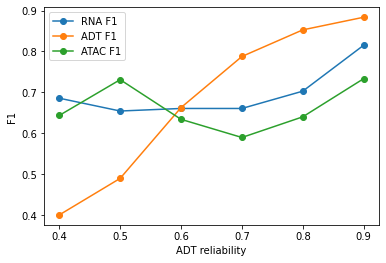

In [15]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-3 DOGMA

In [16]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220218_1/

/ix1/wchen/Haoran/CPDD/ATAC/20220218_1


In [17]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/doublet_20220218_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/doublet_20220218_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_1/doublet_20220218_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/reliability_20220218_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_1/reliability_20220218_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_1/reliability_20220218_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)


0.8033146596055801


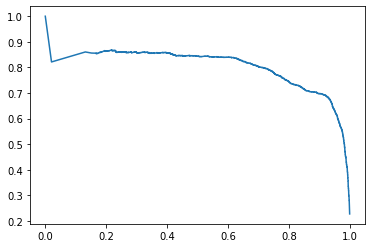

In [18]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [19]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2748364470223241
Precision: 0.7096932515337423
f1 score: 0.7763758389261745


In [20]:
RNA_ks = 0.1373862503596296
ADT_ks = 0.18800334766348065
ATAC_ks = 2*0.1919114811324909

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

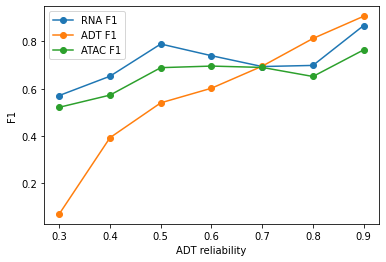

In [21]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-4 DOGMA

In [22]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220218_2/

/ix1/wchen/Haoran/CPDD/ATAC/20220218_2


In [23]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/doublet_20220218_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/doublet_20220218_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_2/doublet_20220218_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/reliability_20220218_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220218_2/reliability_20220218_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220218_2/reliability_20220218_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220218_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()
doublet = doublet.iloc[:, 5].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)


0.7803570146091483


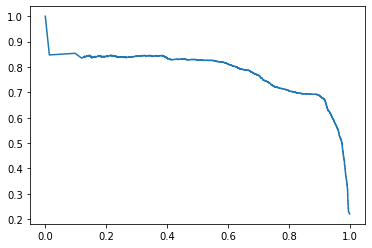

In [24]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 5]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [25]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)


Predicted doublet proportion: 0.26303080275634605
Precision: 0.6970443349753694
f1 score: 0.7583434835566382


In [26]:
RNA_ks = 0.14381163777124115
ADT_ks = 0.20731706214681264
ATAC_ks = 2*0.1793832880375153

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


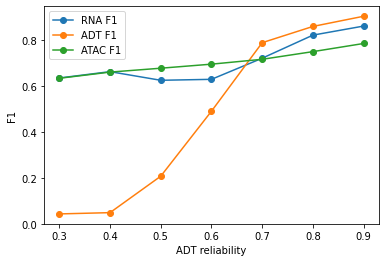

In [27]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-1 DOGMA

In [28]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230124_1/

/ix1/wchen/Haoran/CPDD/ATAC/20230124_1


In [29]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/doublet_20230124_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/doublet_20230124_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_1/doublet_20230124_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/reliability_20230124_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_1/reliability_20230124_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_1/reliability_20230124_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7499788264045155


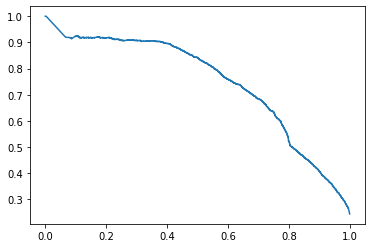

In [30]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [31]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2144989785762925
Precision: 0.7326007326007326
f1 score: 0.6855575868372943


In [32]:
RNA_ks = 0.29722100694307213
ADT_ks = 0.16431229801558517
ATAC_ks = 2*0.17635970874445375

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)
/scratch/slurm-656399/ipykernel_15642/1850087827.py:37: RuntimeWarning: invalid value encountered in scalar divide
  modality_reliability_trend[1,k] = 2*precision_subset*sensitivity_subset/(precision_subset+sensitivity_subset)


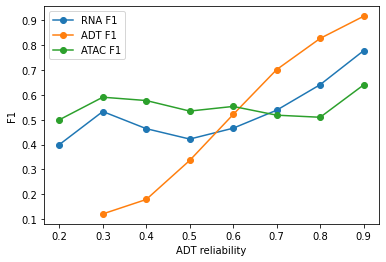

In [33]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-2 DOGMA

In [34]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230124_2/

/ix1/wchen/Haoran/CPDD/ATAC/20230124_2


In [35]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/doublet_20230124_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/doublet_20230124_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_2/doublet_20230124_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/reliability_20230124_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230124_2/reliability_20230124_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230124_2/reliability_20230124_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230124_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7459241738329362


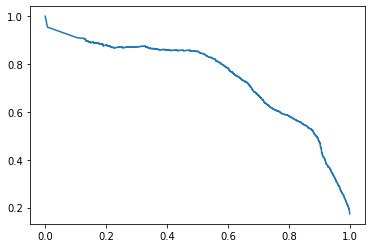

In [36]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [37]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.2440130936656521
Precision: 0.5761355613085432
f1 score: 0.673174755946652


In [38]:
doublet_prediction = pd.DataFrame(combined_prediction, columns = ['prob_doublet'])
doublet_prediction.index.name = 'index'
doublet_prediction.reset_index(inplace=True)
#doublet_prediction = doublet_prediction.sort_values("prob_doublet", ascending = False)
#doublet_prediction
#doublet_prediction.to_csv('doublet_20230124_2_combined.csv',index=False)

In [39]:
RNA_ks = 0.32418501523652565
ADT_ks = 0.1703114580268993
ATAC_ks = 2*0.19730384096764333

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)
/scratch/slurm-656399/ipykernel_15642/1850087827.py:37: RuntimeWarning: invalid value encountered in scalar divide
  modality_reliability_trend[1,k] = 2*precision_subset*sensitivity_subset/(precision_subset+sensitivity_subset)


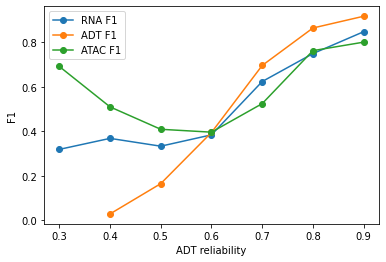

In [40]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-3 DOGMA

In [41]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230126_1/

/ix1/wchen/Haoran/CPDD/ATAC/20230126_1


In [42]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/doublet_20230126_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/doublet_20230126_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_1/doublet_20230126_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/reliability_20230126_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_1/reliability_20230126_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_1/reliability_20230126_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6611450803574993


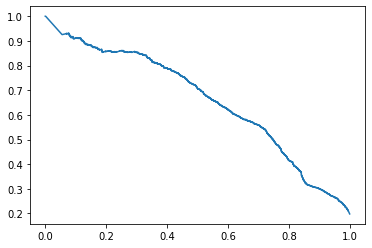

In [43]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [44]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.23935701702877277
Precision: 0.5670039865072064
f1 score: 0.6202616571620262


In [45]:
RNA_ks = 0.3048047535919099
ADT_ks = 0.16657351951273533
ATAC_ks = 2*0.2588966205377892


rna_reliability = np.round(np.power(rna_reliability*RNA_ks, 3),1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(np.power(atac_reliability*ATAC_ks, 3),1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

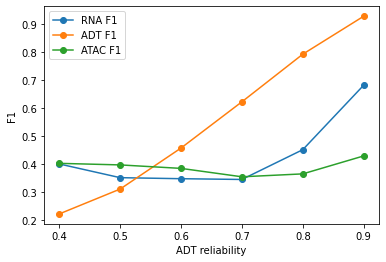

In [46]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-4 DOGMA

In [47]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230126_2/

/ix1/wchen/Haoran/CPDD/ATAC/20230126_2


In [48]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/doublet_20230126_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/doublet_20230126_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_2/doublet_20230126_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/reliability_20230126_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230126_2/reliability_20230126_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230126_2/reliability_20230126_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230126_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6748623168178403


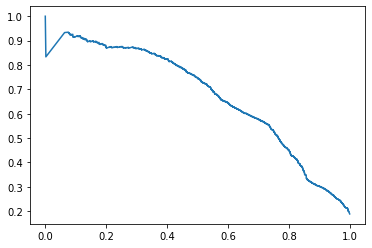

In [49]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [50]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.24738725841088047
Precision: 0.5567129629629629
f1 score: 0.6318555008210179


In [51]:
RNA_ks = 0.3275273490758342
ADT_ks = 0.18765950787239116
ATAC_ks = 2*0.25721424624766037


rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


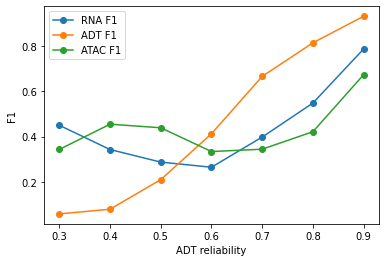

In [52]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-5 DOGMA

In [53]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230203_1/

/ix1/wchen/Haoran/CPDD/ATAC/20230203_1


In [54]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/doublet_20230203_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/doublet_20230203_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_1/doublet_20230203_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/reliability_20230203_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_1/reliability_20230203_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_1/reliability_20230203_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.703746365439684


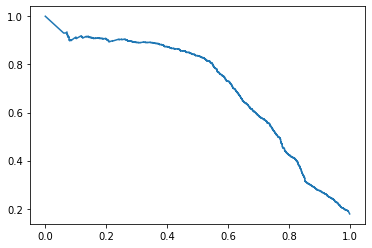

In [55]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [56]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.24389650417714331
Precision: 0.5424010641835717
f1 score: 0.6262238433480515


In [57]:
RNA_ks = 0.2641763761680769
ADT_ks = 0.1652148812093896
ATAC_ks = 2*0.42043289859114946

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:35: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/modality_prediction_subset[label_subset==1].shape[0]
/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


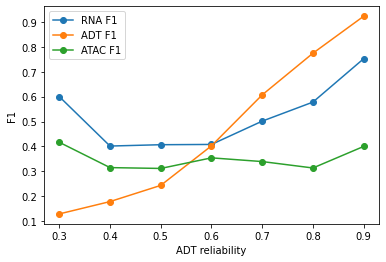

In [58]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-6 DOGMA

In [59]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230203_2/

/ix1/wchen/Haoran/CPDD/ATAC/20230203_2


In [60]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/doublet_20230203_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/doublet_20230203_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_2/doublet_20230203_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/reliability_20230203_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230203_2/reliability_20230203_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230203_2/reliability_20230203_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230203_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.6746033444209284


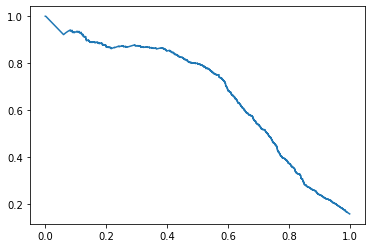

In [61]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [62]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.263187794189255
Precision: 0.4572926302806044
f1 score: 0.5695084485407066


In [63]:
RNA_ks = 0.2650720696684891
ADT_ks = 0.1738687753944817
ATAC_ks = 2*0.4300081795057461

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)
/scratch/slurm-656399/ipykernel_15642/1850087827.py:37: RuntimeWarning: invalid value encountered in scalar divide
  modality_reliability_trend[1,k] = 2*precision_subset*sensitivity_subset/(precision_subset+sensitivity_subset)


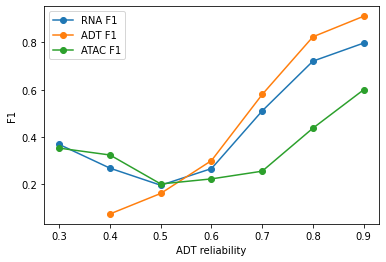

In [64]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## Ileum-7 DOGMA

In [65]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20230206_2/

/ix1/wchen/Haoran/CPDD/ATAC/20230206_2


In [66]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/doublet_20230206_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/doublet_20230206_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230206_2/doublet_20230206_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/reliability_20230206_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20230206_2/reliability_20230206_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20230206_2/reliability_20230206_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20230206_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7166388208718087


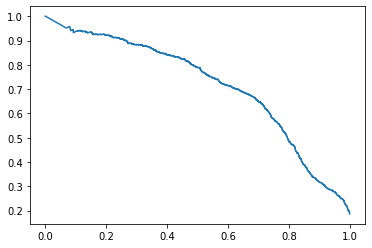

In [67]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [68]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)
print(sen)
print(spe)

Predicted doublet proportion: 0.2539849130862578
Precision: 0.5604338842975206
f1 score: 0.6464104855525766
0.7635467980295566
0.8627751350479723


In [69]:
RNA_ks = 0.2907581902423547
ADT_ks = 0.1795100044702551
ATAC_ks = 2*0.22862192232838222

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:37: RuntimeWarning: invalid value encountered in scalar divide
  modality_reliability_trend[1,k] = 2*precision_subset*sensitivity_subset/(precision_subset+sensitivity_subset)
/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


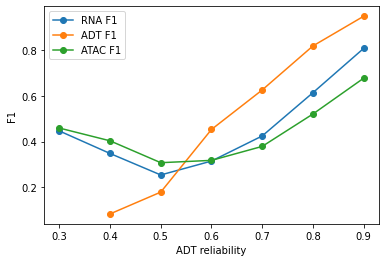

In [70]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-5 DOGMA

In [71]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_1/

/ix1/wchen/Haoran/CPDD/ATAC/20220429_1


In [72]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/doublet_20220429_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/doublet_20220429_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_1/doublet_20220429_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/reliability_20220429_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_1/reliability_20220429_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_1/reliability_20220429_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7823523702567377


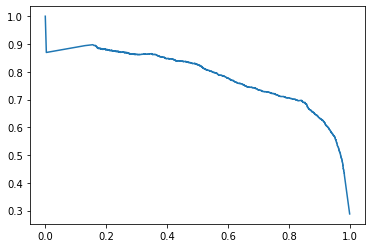

In [73]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [74]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)


Predicted doublet proportion: 0.2538480574115318
Precision: 0.7480990446480795
f1 score: 0.7006939371804236


In [75]:
RNA_ks = 0.23821022553793217
ADT_ks = 0.1506243939762244
ATAC_ks = 2*0.20579993821368808

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:35: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/modality_prediction_subset[label_subset==1].shape[0]
/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


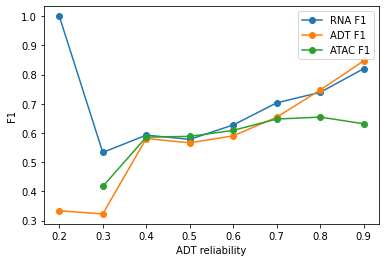

In [76]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-6 DOGMA

In [77]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_2/

/ix1/wchen/Haoran/CPDD/ATAC/20220429_2


In [78]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/doublet_20220429_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/doublet_20220429_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_2/doublet_20220429_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/reliability_20220429_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_2/reliability_20220429_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_2/reliability_20220429_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7474522460933736


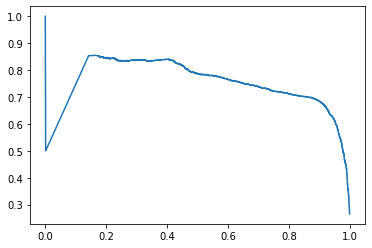

In [79]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [80]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)


Predicted doublet proportion: 0.2891119939869
Precision: 0.7166202414113277
f1 score: 0.747216574692613


In [81]:
RNA_ks = 0.22758671743189657
ADT_ks = 0.17749712350777166
ATAC_ks = 2*0.180467106415942

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

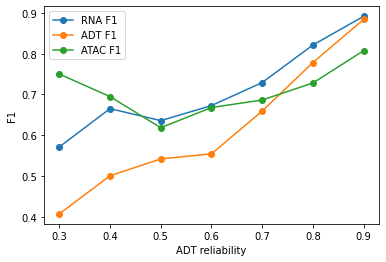

In [82]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-7 DOGMA

In [83]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220429_3/

/ix1/wchen/Haoran/CPDD/ATAC/20220429_3


In [84]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/doublet_20220429_3_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/doublet_20220429_3_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_3/doublet_20220429_3_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/reliability_20220429_3_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220429_3/reliability_20220429_3_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220429_3/reliability_20220429_3_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220429_3/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8190753197223992


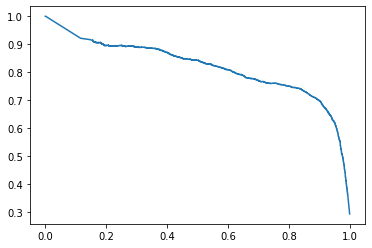

In [85]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [86]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.27364634976183533
Precision: 0.7666074600355239
f1 score: 0.738661646414513


In [87]:
RNA_ks = 0.24421451166091182
ADT_ks = 0.17811009450766702
ATAC_ks = 2*0.18647551876242033

rna_reliability = np.round(rna_reliability*RNA_ks-0.07,1)
adt_reliability = np.round(adt_reliability*ADT_ks-0.07,1)
atac_reliability = np.round(atac_reliability*ATAC_ks-0.07,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

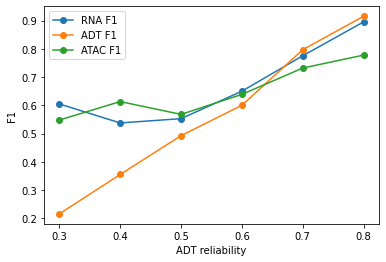

In [88]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-8 DOGMA

In [89]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220524_1/

/ix1/wchen/Haoran/CPDD/ATAC/20220524_1


In [90]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/doublet_20220524_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/doublet_20220524_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_1/doublet_20220524_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/reliability_20220524_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_1/reliability_20220524_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_1/reliability_20220524_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8587723540531924


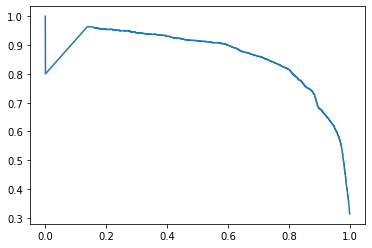

In [91]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [92]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.3584162795841628
Precision: 0.7521599605035794
f1 score: 0.8019476246874588


In [93]:
RNA_ks = 0.18161895586179685
ADT_ks = 0.1911597851132381
ATAC_ks = 2*0.1915035986347527

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

/scratch/slurm-656399/ipykernel_15642/1850087827.py:36: RuntimeWarning: invalid value encountered in scalar divide
  precision_subset = np.sum(modality_prediction_subset[label_subset==1]==1)/np.sum(modality_prediction_subset==1)


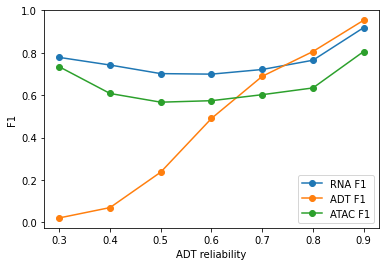

In [94]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-9 DOGMA

In [95]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20220524_2/


/ix1/wchen/Haoran/CPDD/ATAC/20220524_2


In [96]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/doublet_20220524_2_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/doublet_20220524_2_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_2/doublet_20220524_2_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/reliability_20220524_2_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20220524_2/reliability_20220524_2_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20220524_2/reliability_20220524_2_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20220524_2/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.8600497751346587


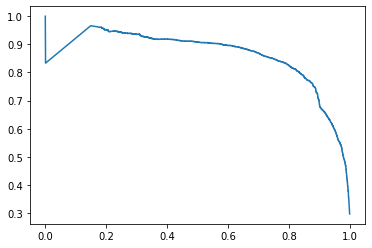

In [97]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]


precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [98]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)

Predicted doublet proportion: 0.3218877471988434
Precision: 0.7842476740455566
f1 score: 0.8157850825963625


In [99]:
RNA_ks = 0.19000365351294582
ADT_ks = 0.18021696936721038
ATAC_ks = 2*0.17857586096514005

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

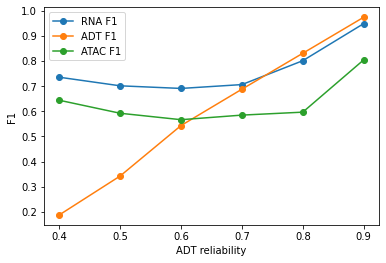

In [100]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()

## PB-10 DOGMA

In [101]:
%cd /ix1/wchen/Haoran/CPDD/ATAC/20210831_1/

/ix1/wchen/Haoran/CPDD/ATAC/20210831_1


In [102]:
atac_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/doublet_20210831_1_atac.csv")
rna_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/doublet_20210831_1_rna.csv")
adt_doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20210831_1/doublet_20210831_1_adt.csv")
atac_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/reliability_20210831_1_atac.csv")
rna_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/RNA/20210831_1/reliability_20210831_1_rna.csv")
adt_reliability = pd.read_csv("/ix1/wchen/Haoran/CPDD/ADT/20210831_1/reliability_20210831_1_adt.csv")
doublet = pd.read_csv("/ix1/wchen/Haoran/CPDD/ATAC/20210831_1/doublet.csv")

atac_doublet = atac_doublet.iloc[:, 1].to_numpy()
rna_doublet = rna_doublet.iloc[:, 1].to_numpy()
adt_doublet = adt_doublet.iloc[:, 1].to_numpy()
atac_reliability = atac_reliability.iloc[:,1].to_numpy()
rna_reliability = rna_reliability.iloc[:,1].to_numpy()
adt_reliability = adt_reliability.iloc[:,1].to_numpy()

doublet = doublet.iloc[:, 1].to_numpy()

reliability_joint = np.stack((atac_reliability, rna_reliability, adt_reliability))
reliability_joint = special.softmax(reliability_joint, axis = 0)

0.7559773821634062


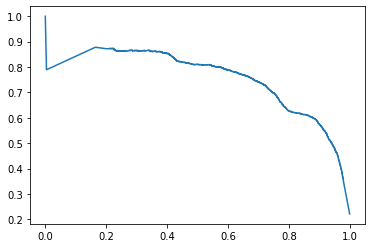

In [103]:
combined_prediction = reliability_joint[0,:]*atac_doublet + reliability_joint[1,:]*rna_doublet + reliability_joint[2,:]*adt_doublet
doublet = pd.read_csv("./doublet.csv")
doublet = doublet.iloc[:, 1]

precision, recall, thresholds = precision_recall_curve(doublet.to_numpy(), combined_prediction)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(recall, precision)
plt.show()

In [104]:
sen, spe = metrics(combined_prediction, doublet, cut = 0.5)


Predicted doublet proportion: 0.27993546156505705
Precision: 0.6309180732811857
f1 score: 0.7040312392328012


In [105]:
RNA_ks = 0.17053267234686278
ADT_ks = 0.16561899397078064
ATAC_ks = 2*0.1988718424215861

rna_reliability = np.round(rna_reliability*RNA_ks,1)
adt_reliability = np.round(adt_reliability*ADT_ks,1)
atac_reliability = np.round(atac_reliability*ATAC_ks,1)

rna_doublet = np.where(rna_doublet > 0.5, 1, 0)
adt_doublet = np.where(adt_doublet > 0.5, 1, 0)
atac_doublet = np.where(atac_doublet > 0.5, 1, 0)

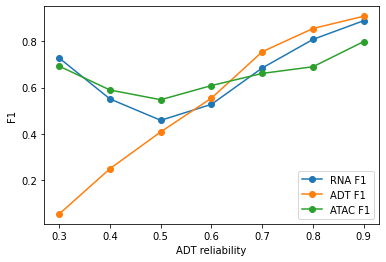

In [106]:
rna_trend = reliability_f1(adt_reliability, rna_doublet, doublet)
adt_trend = reliability_f1(adt_reliability, adt_doublet, doublet)
atac_trend = reliability_f1(adt_reliability, atac_doublet, doublet)

plt.plot(rna_trend[0,1:-1], rna_trend[1,1:-1], 'o-', label = "RNA F1")
plt.plot(adt_trend[0,1:-1], adt_trend[1,1:-1], 'o-', label = "ADT F1")
plt.plot(atac_trend[0,1:-1], atac_trend[1,1:-1], 'o-', label = "ATAC F1")

plt.xlabel("ADT reliability")
plt.ylabel("F1")
plt.legend()